In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from PyQt5.QtWidgets import *
from PyQt5.QtGui import QFont
from SPDFErrors import *

In [2]:
import PyPDF2
from pdf2image import convert_from_path
from PIL import Image

In [3]:
class IDGenerator():
    """
    Creates a unique str id to current IDGenerator object's knowledge.

    Attributes
    ---
    nextID : int
        Next identifier the generator will output
    """
    def __init__(self):
        self.nextID = 0
        
    def generateID(self):
        """
        Returns a string of unique int id and updates nextID to new unique ID.
        
        """
        stringCode = str(self.nextID)
        self.nextID += 1
        return(stringCode)

In [4]:
class PDFPage():
    """
    PDF Page containing both image and PyPDF2 page representation of PDF.
    
    Attributes
    ---
    ID : str
        ID identifying object.
    image : PIL.PpmImagePlugin.PpmImageFile
        PpmImageFile of page for graphical display.
    pageObject : PyPDF2.page.PageObject
        PageObject of pypdf2 page for actually making pdf.

    """
    def __init__(self, ID, image, pageObject):
        self.ID = ID
        self.image = image
        self.pageObject = pageObject
        
    def __eq__(self, obj):
        if obj is self:
            return(True)
        elif not isinstance(obj, PDFPage):
            return(False)
        else:
            return((obj.getID() == self.getID()) and
                   (obj.getImage() == self.getImage()) and
                   (obj.getPageObject() == self.getPageObject()))
        
    def getID(self):
        return(self.ID)
    
    def getImage(self):
        return(self.image)
    
    def getPageObject(self):
        return(self.pageObject)

In [5]:
class PDFPageBank():
    """
    Bank of all PDFPages added so far.
    
    Attributes
    ---
    map : dict
        Dictionary of pdfPages with key of PDFPage's ID and value of PDFPage.
    
    """

    def __init__(self):
        self.map = {}
    
    def contains(self, ID):
        """
        Returns true if pdfPage ID is in page bank.
        
        Parameters
        ---
        ID : str
            ID to check if in.
        
        Returns
        ---
        bool
            True if is in, false otherwise.
        
        """
        return(ID in self.map.keys())
    
    def addPage(self, pdfPage):
        """
        Adds pdfPage to dictionary with its ID as its key.
        
        Parameters
        ---
        pdfPage : PDFPage
            PDFPage to add to bank.
            
        Raises
        ---
        NotUniqueError
            Raised if pdfPage with matching key is already added to bank.
            
        """
        if not self.contains(pdfPage.getID()):
            self.map[pdfPage.getID()] = pdfPage
        else:
            raise NotUniqueError('PDFPage exists in PDFPageBank already.')
        
    
    def getPage(self, ID):
        """
        Gets pdfPage with corresponding ID.
        
        Parameters
        ---
        ID : str
            ID of page to get.

        Returns
        ---
        PDFPage
            Page with matching ID.
            
        Raises
        ---
        NotInBankError
            Raised if no page has a matching ID.
        
        """
        if self.contains(ID):
            return(self.map.get(ID))
        else:
            raise NotInBankError('No PDFPage with given ID in Bank.')

    def countPages(self):
        """
        Returns int of number of pages in bank.
        
        """
        return(len(self.map.keys()))

In [13]:
class PDF():
    """
    Ordered collection of References to PDFPage IDs in PDFPageBank.
    
    Attributes
    ---
    orderedPages : list
        List of ordered PDFPage IDs representing PDF.
    pageBank : PDFPageBank
        PDFPageBank where PDFPages in PDF are located.

    Notes
    ---
    Iterable of PDFPage.
    
    """

    def __init__(self, pageBank):
        self.orderedPages = []
        self.pageBank = pageBank
    
    def __iter__(self):
        self.currentIndex = 0
        return(self)
    
    def __next__(self):
        if self.currentIndex  < self.countPages():
            page = self.getPage(self.currentIndex)
            self.currentIndex += 1
            return(page)
        else:
            raise(StopIteration)
    
    def addPage(self, pdfPage):
        """
        Adds PDFPage Object to end of PDF if is in pageBank.
        
        Parameters
        ---
        pdfPage : PDFPage
            PDFPage to add to bank.
            
        Raises
        ---
        NotInBankError
            Raised if pdfPage not in bank yet.

        """
        if self.pageBank.contains(pdfPage.getID()):
            self.orderedPages.append(pdfPage.getID())
        else:
            raise(NotInBankError("PDFPage not in pagebank."))
    
    def getPage(self, i):
        """
        Returns reference to pdfPage of index i from PDF, grabbed from page bank. 
        
        """
        return(self.pageBank.getPage(self.orderedPages[i]))

    def countPages(self):
        """
        Returns int of number of pages in PDF.
        
        """
        return(len(self.orderedPages))

    def appendEntirePDF(self, pdf):
        """
        Appends all pages in pdf to the end of self.
            
        Raises
        ---
        NotInBankError
            Raised if any pages in pdf are not in the same bank as this pdf.

        """
        for p in pdf:
            self.addPage(p)

        

In [7]:
class file2PDFConverter():
    
    def __init__(self, filePath, idGenerator, pdfBank):
        self.reader = PyPDF2.PdfFileReader(filePath)
        self.images = convert_from_path(filePath)
        self.generator = idGenerator
        self.bank = pdfBank
    
    def extractPDF(self):
        """
        Extracts and returns PDF object of given filePath

        Returns
        ---
        PDF
             PDF containing ordered pages in same form as PDF from filePath
        """
        pdf = PDF(self.bank)
        for i in range(self.reader.getNumPages()):
            page = PDFPage(self.generator.generateID(),
                           self.images[i],
                           self.reader.getPage(i))
            self.bank.addPage(page)
            pdf.addPage(page)
        return(pdf)

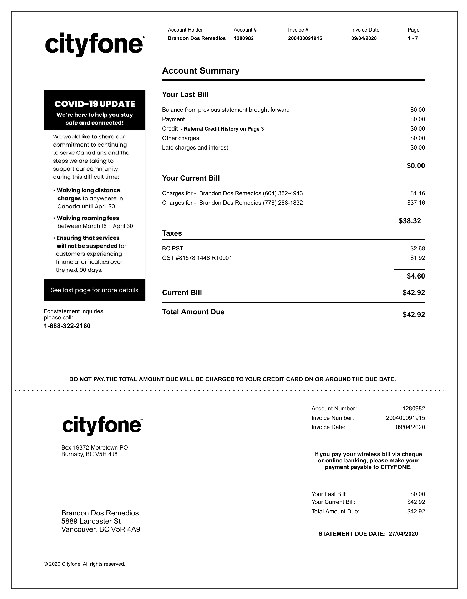

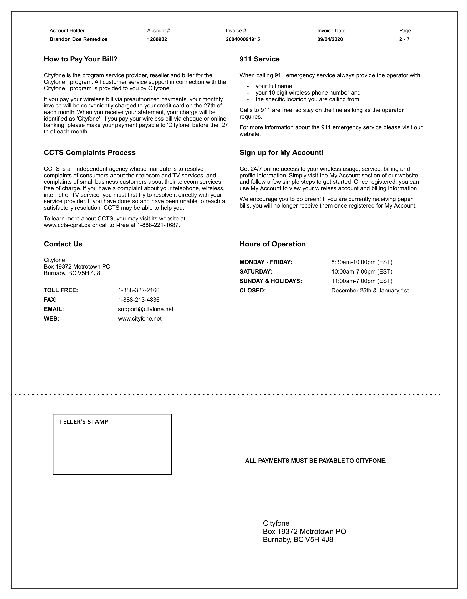

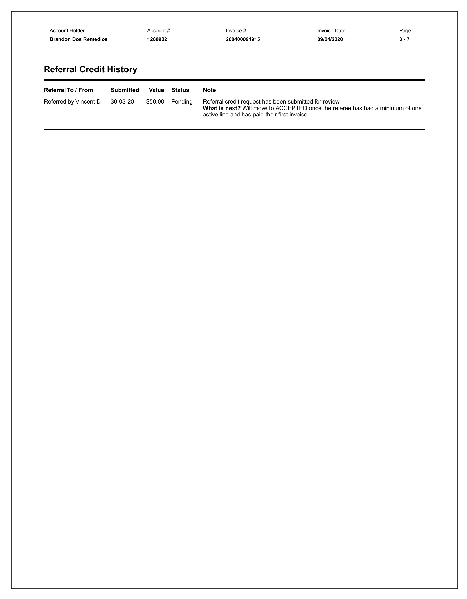

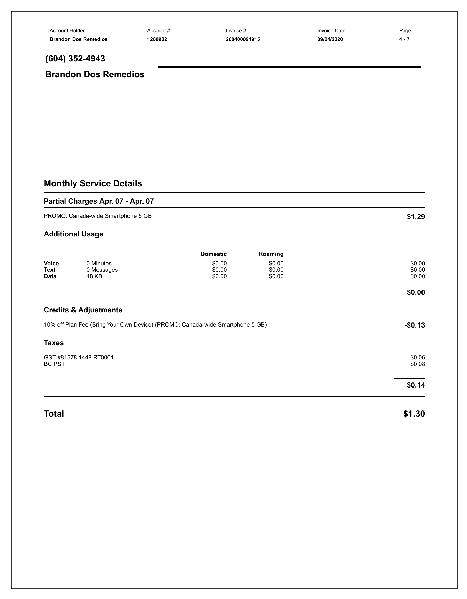

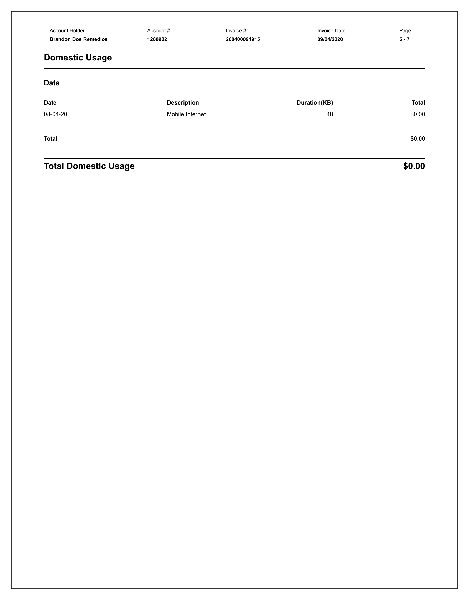

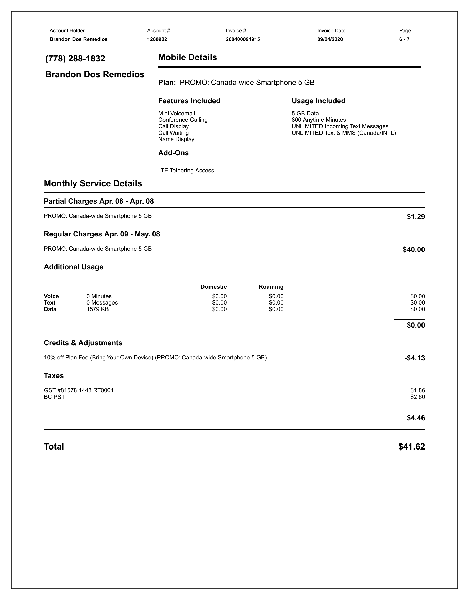

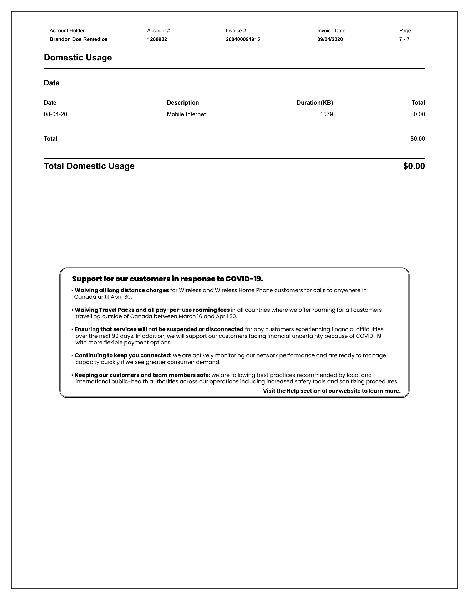

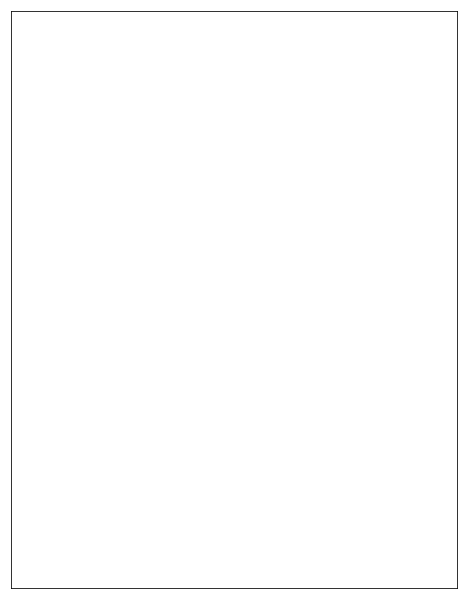

In [8]:
converter = file2PDFConverter('C:/Users/dosre/Downloads/invoice_200400091915.pdf', IDGenerator(), PDFPageBank())
pdf = converter.extractPDF()
for p in pdf:
    fig, ax = plt.subplots(figsize=(8, 11))
    ax.imshow(p.getImage())
    ax.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

In [17]:
import unittest

class testIDGenerator(unittest.TestCase):

    def testGenerateID(self):
        generator = IDGenerator()
        firstCode = generator.generateID()
        secondCode = generator.generateID()
        self.assertTrue(firstCode != secondCode)
        thirdCode = generator.generateID()
        self.assertTrue(thirdCode != firstCode)
        self.assertTrue(thirdCode != secondCode)

        
class testPDFPage(unittest.TestCase):
    
    def setUp(self):
        self.page1 = PDFPage('key1', None, None)
        self.page2 = PDFPage('key2', None, None)
    
    def testConstructor(self):
        self.assertTrue(self.page1.getID() != self.page2.getID())
        self.assertTrue(self.page1.getImage() is None)
        self.assertTrue(self.page1.getPageObject() is None)
    
    def testEq(self):
        self.assertTrue(self.page1 == self.page1)
        self.assertFalse(self.page1 == None)
        self.assertTrue(self.page1 == PDFPage(self.page1.getID(), None, None))

        
class testPDFPageBank(unittest.TestCase):

    def setUp(self):
        self.bank = PDFPageBank()
        self.page1 = PDFPage('key1', None, None)
        self.page2 = PDFPage('key2', None, None)
    
    def testConstructor(self):
        self.assertTrue(self.bank is not None)
    
    def testAddGetPage(self):
        self.bank.addPage(self.page1)
        self.bank.addPage(self.page2)
        self.assertEqual(self.bank.getPage(self.page1.getID()), self.page1)
        self.assertEqual(self.bank.getPage(self.page2.getID()), self.page2)
    
    def testAddSamePage(self):
        try:
            self.bank.addPage(self.page1)
            self.bank.addPage(self.page1)
            self.fail('Should have raised exception.')
        except(NotUniqueError):
            pass
    
    def testGetPageNotInBank(self):
        try:
            self.bank.getPage('notakey')
            self.fail('Should have raised exception.')
        except(NotInBankError):
            pass

    def testCountPages(self):
        self.assertEqual(self.bank.countPages(), 0)
        self.bank.addPage(self.page1)
        self.assertEqual(self.bank.countPages(), 1)
        self.bank.addPage(self.page2)
        self.assertEqual(self.bank.countPages(), 2)


class testPDF(unittest.TestCase):
    
    def setUp(self):
        self.bank = PDFPageBank()
        self.page1 = PDFPage('key1', None, None)
        self.page2 = PDFPage('key2', None, None)
        self.bank.addPage(self.page1)
        self.bank.addPage(self.page2)
        self.pdf = PDF(self.bank)
    
    def testConstructor(self):
        self.assertTrue(self.pdf is not None)
    
    def testAddGetPage(self):
        self.pdf.addPage(self.page1)
        self.pdf.addPage(self.page2)
        self.assertEqual(self.pdf.getPage(0), self.page1)
        self.assertEqual(self.pdf.getPage(1), self.page2)
    
    def testAddPageNotInBank(self):
        try:
            self.pdf.addPage(PDFPage('key3', None, None))
            self.fail('Should not have added PDFPage w key3 as is not in bank.')
        except(NotInBankError):
            pass

    def testCountPages(self):
        self.assertEqual(self.pdf.countPages(), 0)
        self.pdf.addPage(self.page1)
        self.assertEqual(self.pdf.countPages(), 1)
        self.pdf.addPage(self.page2)
        self.assertEqual(self.pdf.countPages(), 2)
    
    def test0LengthIterator(self):
        for p in self.pdf:
            self.fail('Nothing should have run in for loop since no elements.')
    
    def test2LengthIterator(self):
        self.pdf.addPage(self.page1)
        self.pdf.addPage(self.page2)
        for p in self.pdf:
            pass
        iterable = iter(self.pdf)
        self.assertEqual(next(iterable), self.page1)
        self.assertEqual(next(iterable), self.page2)
    
    def testAppendEntirePDF(self):
        self.pdf.addPage(self.page1)
        self.pdf.addPage(self.page2)
        pdf2 = PDF(self.bank)
        page3 = PDFPage('key3', None, None)
        page4 = PDFPage('key4', None, None)
        self.bank.addPage(page3)
        self.bank.addPage(page4)
        pdf2.addPage(page3)
        pdf2.addPage(page4)
        self.pdf.appendEntirePDF(pdf2)
        iterable = iter(self.pdf)
        self.assertEqual(next(iterable), self.page1)
        self.assertEqual(next(iterable), self.page2)
        self.assertEqual(next(iterable), page3)
        self.assertEqual(next(iterable), page4)
    
    def testAppendEntirePDFNotInBank(self):
        self.pdf.addPage(self.page1)
        self.pdf.addPage(self.page2)
        otherBank = PDFPageBank()
        pdf2 = PDF(otherBank)
        page3 = PDFPage('key3', None, None)
        otherBank.addPage(page3)
        pdf2.addPage(page3)
        try:
            self.pdf.appendEntirePDF(pdf2)
            self.fail('Page3 not in bank so should have failed.')
        except(NotInBankError):
            pass

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

................
----------------------------------------------------------------------
Ran 16 tests in 0.013s

OK


In [10]:
# GUI Application

class selectFileGUI(QDialog):

    def __init__(self):
        super().__init__()
        self._setUI()
        self.exec_()
        self.raise_()
        self.activateWindow()
        self.move(int(QDesktopWidget().availableGeometry().center().x()-self.width()/2.),
                  int(QDesktopWidget().availableGeometry().center().y()-self.height()/2.))
    
    def _setUI(self):
        """
        Sets buttons and line edit widgets in main QDialog.
        
        """
        self.setWindowTitle('Select PDF to Edit')
        layout = QGridLayout()
        
        fileName = QLineEdit()
        layout.addWidget(fileName, 0, 0, 1, 2)
        
        browse = QPushButton('Browse')
        browse.clicked.connect(lambda: self._handleFileDialog(fileName))
        layout.addWidget(browse, 0, 2)
        
        editPDF = QPushButton('Edit PDF')
        editPDF.clicked.connect(lambda: self._handleEditPDFButton(fileName.text()))
        layout.addWidget(editPDF, 1, 0)
        
        newPDF = QPushButton('New PDF')
        newPDF.clicked.connect(lambda: print('New'))
        layout.addWidget(newPDF, 1, 1)

        self.setLayout(layout)

    def _handleFileDialog(self, qLineEdit):
        """
        Opens QFileDialog and changes qLineEdit text to file selected.
        
        """
        dialog = QFileDialog()
        dialog.open(lambda: qLineEdit.setText(dialog.selectedFiles()[0]))
        dialog.exec_()
    
    def _handleEditPDFButton(self, fileName):
        """
        Checks fileName to see if is pdf file and that it exists, opening application
        if is, and opening error dialog if not.
        
        Parameters
        ---
        fileName : str
            fileName to check for validity
        
        """
        errorText = ''
        if (re.fullmatch('.*\.pdf/?', fileName) is None):
            errorText += 'File must be pdf.\n'
        if (not os.path.isfile(fileName)):
            errorText += 'File does not exist.\n'
        if errorText != '':
            errorBox = QMessageBox()
            errorBox.setWindowTitle('File Error')
            errorBox.setText(errorText)
            errorBox.setIcon(QMessageBox.Warning)
            errorBox.exec_()
        else:
            ### Application activation goes here
            None



In [ ]:
class editPDFGUI

In [ ]:
if __name__ == '__main__':
    app = QApplication([])
    gui = selectFileGUI()  # var assignment prevents immediate garbage collection for some reason
    app.exec_()